In [1]:
# Data commands:
# `python download_data.py --project=feature_recycling-nlg_ablation_v2`

In [2]:
import re
import sys

sys.path.append('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display

from plotting_utils import *

sns.set_theme('notebook', 'white')
%matplotlib inline

In [3]:
save_path = 'figures/'
config_data_path = 'data/ablation_config_data.csv'
run_data_path = f'data/ablation_run_data.csv'

all_sweeps_config_df = pd.read_csv(config_data_path, index_col=0)
all_sweeps_config_df['run_id'] = all_sweeps_config_df['id']
all_sweeps_config_df = flatten_config_df(all_sweeps_config_df)
all_sweeps_run_df = pd.read_csv(run_data_path, index_col=0)

sweep_name_map = {
    'xwf0pcuf': 'distractors',
    'oqmepiyy': 'non_stationary_target',
    'dj7czodp': 'noisy_target',
    'jk4drneq': 'target_hidden_dim',
    '3o8wad6y': 'input_count'
}

# Split up dfs by sweep name
run_dfs = {}
config_dfs = {}
for sweep_id, sweep_name in sweep_name_map.items():
    config_dfs[sweep_name] = all_sweeps_config_df[all_sweeps_config_df['sweep'] == sweep_id].reset_index(drop=True)
    run_ids = set(config_dfs[sweep_name]['run_id'].unique())
    run_dfs[sweep_name] = all_sweeps_run_df[all_sweeps_run_df['run_id'].isin(run_ids)].reset_index(drop=True)

# Add in an extra baseline df
config_dfs['baseline'] = config_dfs['distractors'][config_dfs['distractors']['task.distractor_chance'] == 0]
vanilla_run_ids = set(config_dfs['baseline']['run_id'].unique())
run_dfs['baseline'] = run_dfs['distractors'][run_dfs['distractors']['run_id'].isin(vanilla_run_ids)]

In [7]:
run_dfs['distractors'][run_dfs['distractors']['loss'].isna()]

,step,layer_1/distractor_input_l1,samples,loss,layer_0/real_weight_l1,units_pruned,_runtime,layer_1/real_input_l1,layer_0/distractor_input_l1,n_distractors,mean_prediction_loss,layer_0/real_input_l1,layer_1/distractor_weight_l1,cumulative_loss,squared_targets,_timestamp,layer_0/distractor_weight_l1,layer_1/real_weight_l1,fraction_pruned_were_new,run_id
65000,0.0,0.531752,0.0,NaN,0.431250,0.0,1.439351,0.442029,0.811345,182,0.001228,0.811345,NaN,NaN,NaN,1.748514e+09,0.431250,NaN,NaN,i4z2fr1p
65001,200.0,0.523608,200.0,NaN,0.431250,320.0,1.680159,0.500000,0.773832,182,NaN,0.773832,NaN,NaN,0.988662,1.748514e+09,0.431250,NaN,0.746875,i4z2fr1p
65002,400.0,0.524008,400.0,NaN,0.434375,640.0,1.925021,0.546763,0.652557,181,NaN,0.652557,NaN,NaN,0.897546,1.748514e+09,0.434375,NaN,0.750000,i4z2fr1p
65003,600.0,0.526747,600.0,NaN,0.434375,960.0,2.165118,0.489209,0.838273,181,NaN,0.838273,NaN,NaN,0.984373,1.748514e+09,0.434375,NaN,0.750000,i4z2fr1p
65004,800.0,0.487101,800.0,NaN,0.437500,1280.0,2.402996,0.442857,0.686577,180,NaN,0.686577,NaN,NaN,0.938750,1.748514e+09,0.437500,NaN,0.750000,i4z2fr1p
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739995,999000.0,0.511229,999000.0,NaN,0.010449,102297600.0,5361.750410,0.518692,0.733539,20266,NaN,0.733539,NaN,NaN,1.002668,1.748533e+09,0.010449,NaN,0.996094,aph1hqmx
739996,999200.0,0.510819,999200.0,NaN,0.010498,102318080.0,5362.804925,0.530233,0.809982,20265,NaN,0.809982,NaN,NaN,0.971971,1.748533e+09,0.010498,NaN,0.996094,aph1hqmx
739997,999400.0,0.517135,999400.0,NaN,0.010400,102338560.0,5363.861459,0.539906,0.853818,20267,NaN,0.853818,NaN,NaN,1.006128,1.748533e+09,0.010400,NaN,0.996094,aph1hqmx
739998,999600.0,0.513007,999600.0,NaN,0.010498,102359040.0,5364.921810,0.539535,0.990188,20265,NaN,0.990188,NaN,NaN,1.029931,1.748533e+09,0.010498,NaN,0.996094,aph1hqmx


In [6]:
def plot_ablation_figure(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model.hidden_dim', metric_type='cumulative', # {'cumulative', 'final'}
    ):
    if metric_type.lower() == 'cumulative':
        final_step_df = run_df.sort_values('step').groupby('run_id').last().reset_index()
        final_step_df = final_step_df.merge(config_df, on='run_id', how='left')
        y_col = 'cumulative_loss'
        y_label = f'Cumulative {y_label}'
        
    elif metric_type.lower() == 'final':
        
        
        # Get the last 5% of steps for each run
        max_steps_per_run = run_df.groupby('run_id')['step'].max()
        threshold_steps = max_steps_per_run * 0.95

        # Filter for last 5% of steps and calculate mean loss
        final_loss_df = run_df.merge(
            threshold_steps.rename('threshold_step'),
            left_on='run_id',
            right_index=True
        )
        final_loss_df = final_loss_df[final_loss_df['step'] >= final_loss_df['threshold_step']]
        final_loss_df = final_loss_df.groupby('run_id')['loss'].mean().reset_index()
        
        # Merge with config data
        final_loss_df = final_loss_df.merge(config_df, on='run_id', how='left')
        final_step_df = final_loss_df

        y_col = 'loss'
        y_label = f'{y_label} (Final 5%)'
        
    else:
        raise ValueError(f"Invalid metric type: {metric_type}!")

    # Create a mapping of actual values to evenly spaced positions
    x_values = sorted(final_step_df[x_col].unique())
    x_positions = np.arange(len(x_values))
    x_map = dict(zip(x_values, x_positions))

    # Create temporary column with evenly spaced x positions
    final_step_df['x_position'] = final_step_df[x_col].map(x_map)

    # Create plot with evenly spaced x positions
    sns.lineplot(
        data = final_step_df,
        x = 'x_position',
        y = y_col, 
        hue = hue_col,
        marker = 'o',
        palette = 'deep',
        errorbar = None,
    )

    # Customize plot
    plt.grid(True, alpha=0.4)  # Add light grid
    plt.xlim(-0.1, len(x_values) - 0.9)  # Add small padding on both sides
    plt.xticks(x_positions, x_values)  # Use original values as labels
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend(title='# Hidden Units')


def plot_ablation_comparison(
        run_df, config_df, x_col, title, x_label, y_label,
        hue_col='model.hidden_dim', figsize=(12, 5),
    ):
    """Creates side-by-side plots comparing cumulative and final metrics.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data 
        x_col: Column to plot on x-axis
        title: Title for the overall figure
        x_label: Label for x-axis
        y_label: Label for y-axis
        hue_col: Column to use for line colors
        figsize: Figure size as (width, height) tuple
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    plt.sca(ax1)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'cumulative'
    )
    
    plt.sca(ax2)
    plot_ablation_figure(
        run_df = run_df,
        config_df = config_df,
        x_col = x_col,
        title = title,
        x_label = x_label,
        y_label = y_label,
        hue_col = hue_col,
        metric_type = 'final'
    )
    
    plt.tight_layout()

In [7]:
def plot_learning_curves(
        run_df,
        config_df,
        subplot_col,
        subplot_values = None,
        n_bins = 200,
        figsize = (12, 10),
        max_cols = 2,
        subplot_col_label = None,
        same_y_axis = True,
    ):
    """Creates subplots of learning curves for different values of a variable.
    
    Args:
        run_df: DataFrame containing run data
        config_df: DataFrame containing config data
        subplot_col: Column name to split subplots by
        subplot_values: List of values to plot. If None, uses all unique values
        n_bins: Number of bins for the learning curves
        figsize: Figure size as (width, height) tuple
        max_cols: Maximum number of columns in subplot grid
        subplot_col_label: Label for the subplot column
        same_y_axis: Whether all subplots should share the same y-axis scale
    """
    # Get full dataset
    plot_df = run_df.merge(config_df, on='run_id', how='left')
    
    # Get subplot values if not provided
    if subplot_values is None:
        subplot_values = sorted(plot_df[subplot_col].unique())
    
    # Calculate number of rows/cols for subplots
    n_plots = len(subplot_values)
    n_cols = min(max_cols, n_plots)
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # Create figure
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    # Calculate mid 98% percentile for consistent y-axis if requested
    if same_y_axis:
        filtered_df = plot_df[
            (plot_df['loss'] >= np.percentile(plot_df['loss'], 1)) &
            (plot_df['loss'] <= np.percentile(plot_df['loss'], 99))
        ]
        y_range = filtered_df['loss'].max() - filtered_df['loss'].min()
        y_pad = y_range * 0.1
        y_min = filtered_df['loss'].min() - y_pad
        y_max = filtered_df['loss'].max() + y_pad

    # Get max step value for x-axis limit
    max_step = plot_df['step'].max()

    for i, val in enumerate(subplot_values):
        # Filter for current value
        curr_df = plot_df[plot_df[subplot_col] == val].copy()
        
        # Bin data
        curr_df = bin_df(curr_df, n_bins=n_bins)
        curr_df = curr_df[curr_df['model.hidden_dim'].notna()]  # Remove NaN values
        curr_df['model.hidden_dim'] = curr_df['model.hidden_dim'].astype(int)
        
        # Create subplot
        sns.lineplot(
            data = curr_df,
            x = 'step',
            y = 'loss',
            hue = 'model.hidden_dim', 
            palette = 'deep',
            errorbar = None,
            ax = axes[i]
        )
        
        # Customize subplot
        axes[i].grid(True, alpha=0.4)
        axes[i].set_xlim(0, max_step)
        if same_y_axis:
            axes[i].set_ylim(y_min, y_max)
        else:
            # Calculate y limits for this subplot
            filtered_curr_df = curr_df[
                (curr_df['loss'] >= np.percentile(curr_df['loss'], 1)) &
                (curr_df['loss'] <= np.percentile(curr_df['loss'], 99))
            ]
            y_range = filtered_curr_df['loss'].max() - filtered_curr_df['loss'].min()
            y_pad = y_range * 0.1
            axes[i].set_ylim(
                filtered_curr_df['loss'].min() - y_pad,
                filtered_curr_df['loss'].max() + y_pad
            )
        axes[i].set_title(f'{subplot_col_label if subplot_col_label else subplot_col} = {val}')
        axes[i].set_xlabel('step (binned)')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        axes[i].set_ylabel('loss')
        
        # Only show legend on first subplot
        if i > 0:
            axes[i].get_legend().remove()
        else:
            axes[i].legend(title='# Hidden Units')
    
    # Remove any extra subplots
    for i in range(len(subplot_values), len(axes)):
        fig.delaxes(axes[i])
    
    # Add overall title if provided
    if subplot_col_label:
        plt.suptitle(f'Learning Curves for {subplot_col_label}')
        
    plt.tight_layout()

## Input Feature Count Ablation

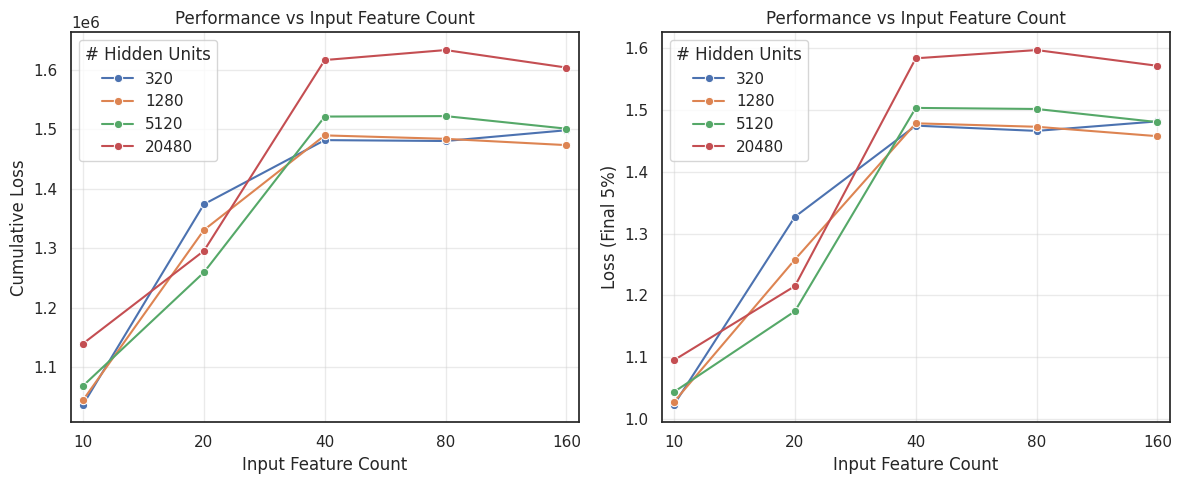

In [8]:
plot_ablation_comparison(
    run_df = run_dfs['input_count'],
    config_df = config_dfs['input_count'],
    x_col = 'task.n_features',
    title = 'Performance vs Input Feature Count',
    x_label = 'Input Feature Count',
    y_label = 'Loss',
)

ValueError: Axis limits cannot be NaN or Inf

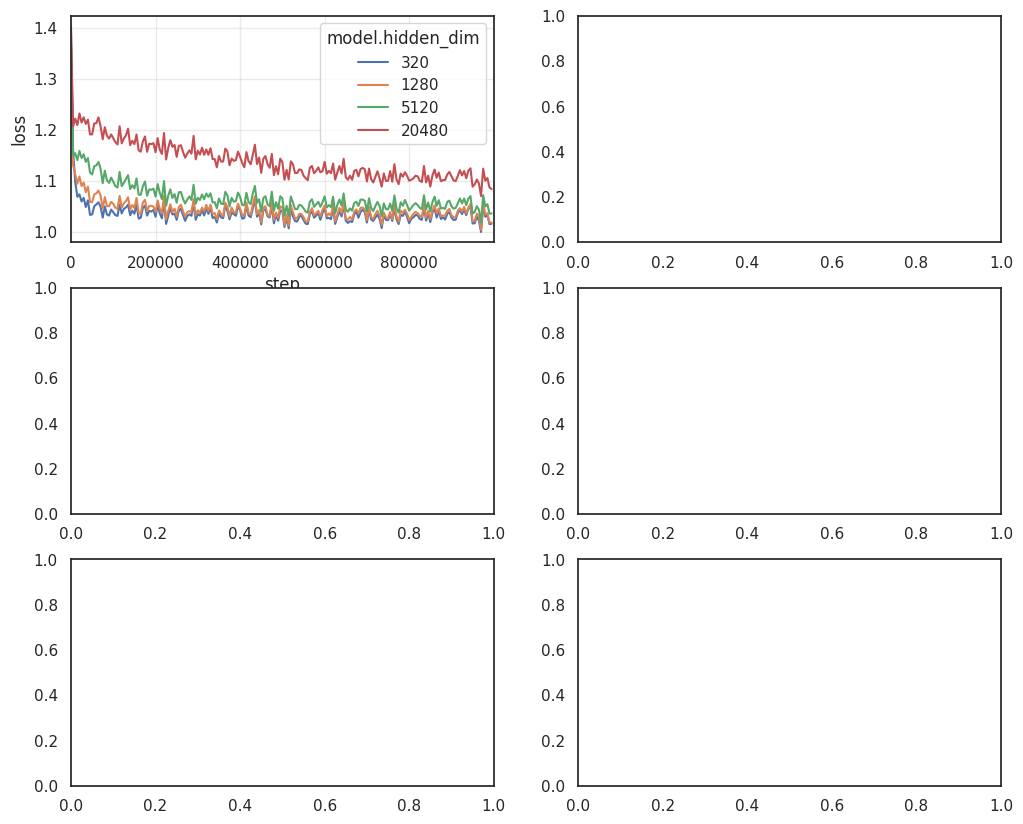

In [9]:
plot_learning_curves(
    run_df = run_dfs['input_count'],
    config_df = config_dfs['input_count'],
    subplot_col = 'task.n_features',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Input Feature Count',
)

## Target Hidden Dim Ablation

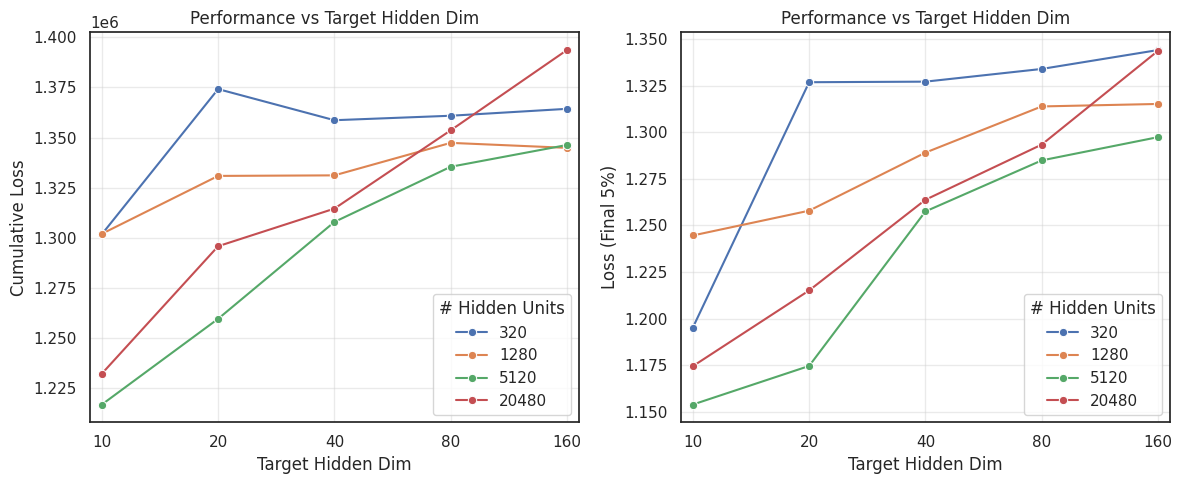

In [10]:
plot_ablation_comparison(
    run_df = run_dfs['target_hidden_dim'],
    config_df = config_dfs['target_hidden_dim'],
    x_col = 'task.hidden_dim',
    title = 'Performance vs Target Hidden Dim',
    x_label = 'Target Hidden Dim',
    y_label = 'Loss',
)

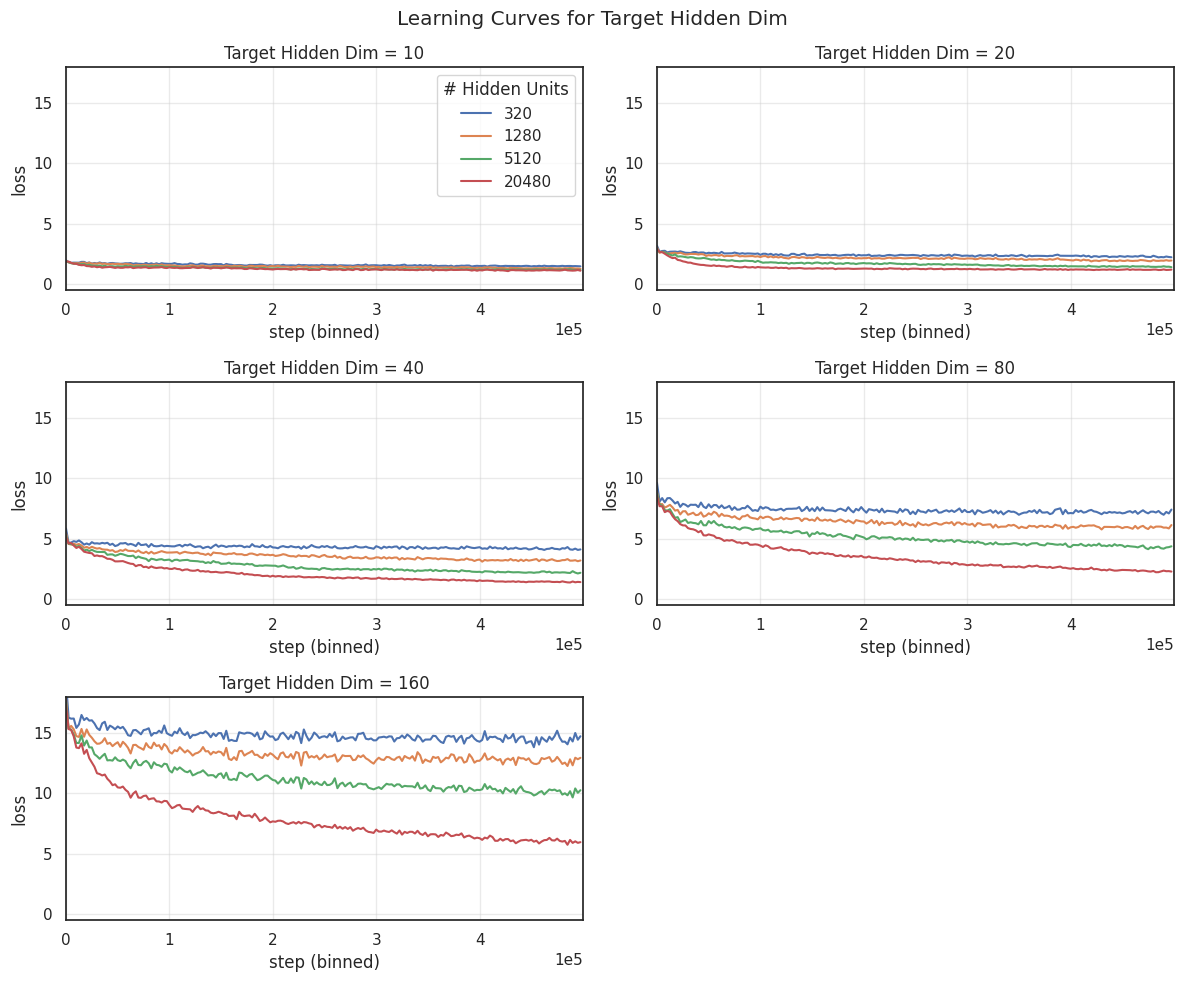

In [68]:
plot_learning_curves(
    run_df = run_dfs['target_hidden_dim'],
    config_df = config_dfs['target_hidden_dim'],
    subplot_col = 'task.hidden_dim',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Target Hidden Dim',
)

## Distractor Count Ablation

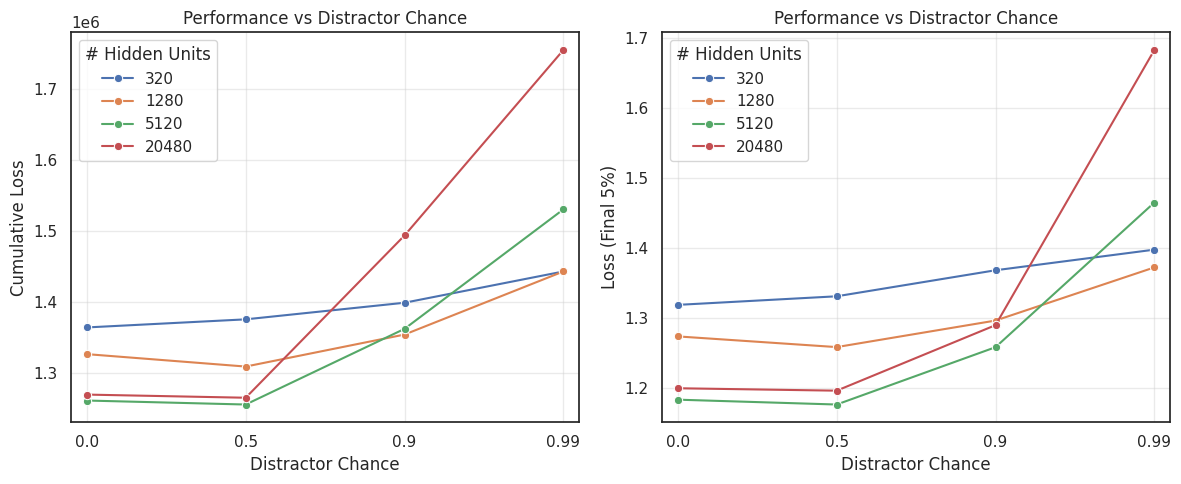

In [11]:
plot_ablation_comparison(
    run_df = run_dfs['distractors'],
    config_df = config_dfs['distractors'],
    x_col = 'task.distractor_chance',
    title = 'Performance vs Distractor Chance',
    x_label = 'Distractor Chance',
    y_label = 'Loss',
)

ValueError: Axis limits cannot be NaN or Inf

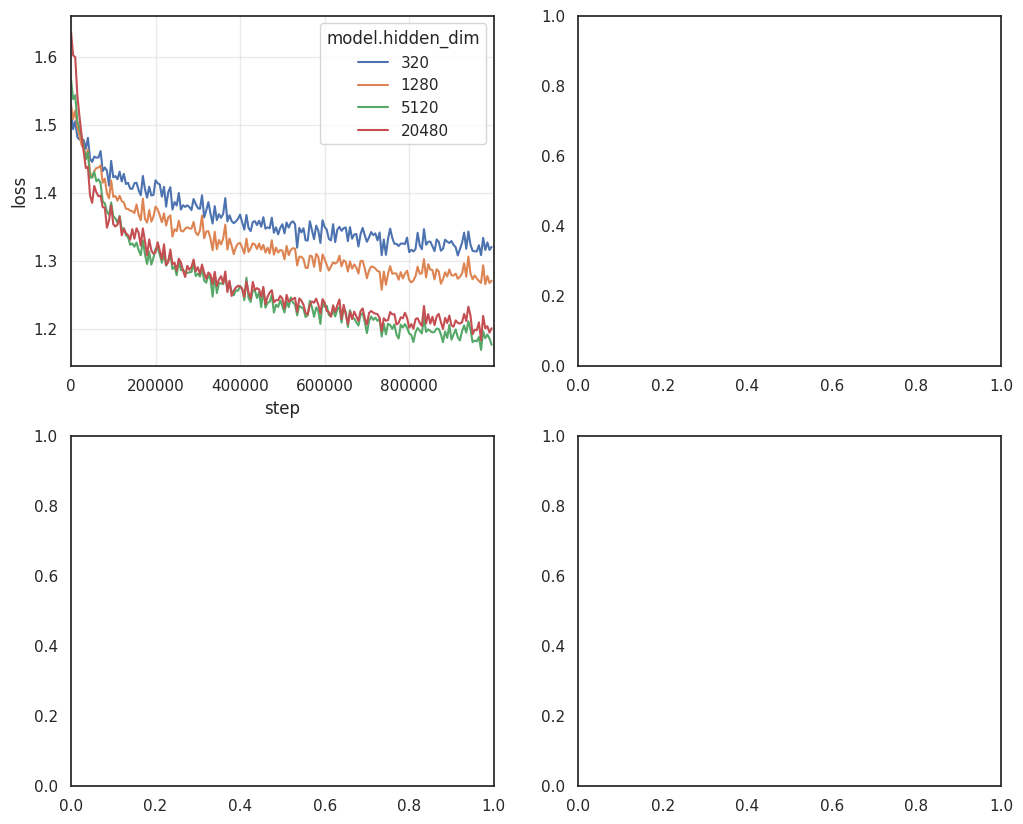

In [12]:
plot_learning_curves(
    run_df = run_dfs['distractors'],
    config_df = config_dfs['distractors'],
    subplot_col = 'task.distractor_chance',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Distractor Chance',
)

## Noisy Target Ablation

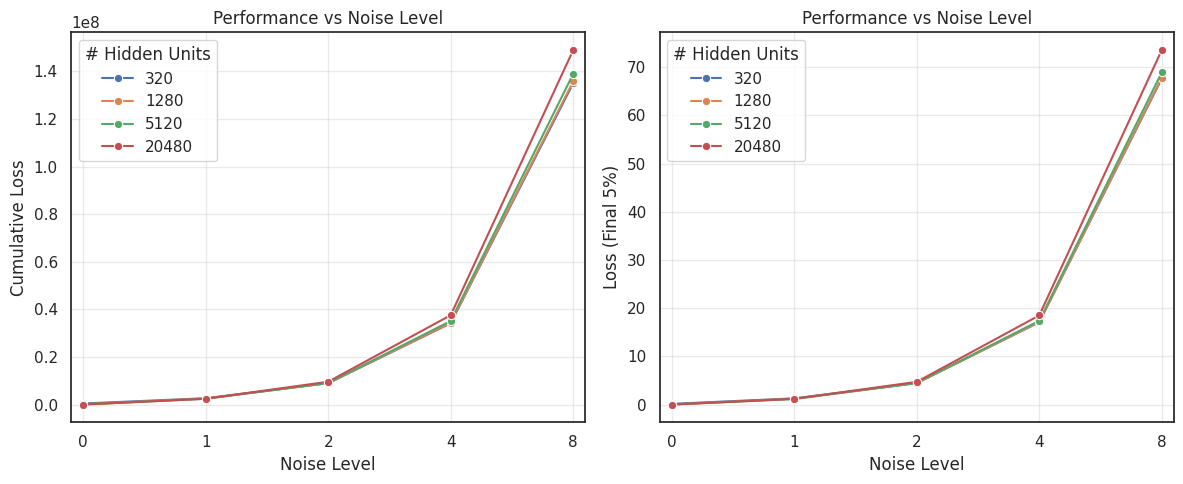

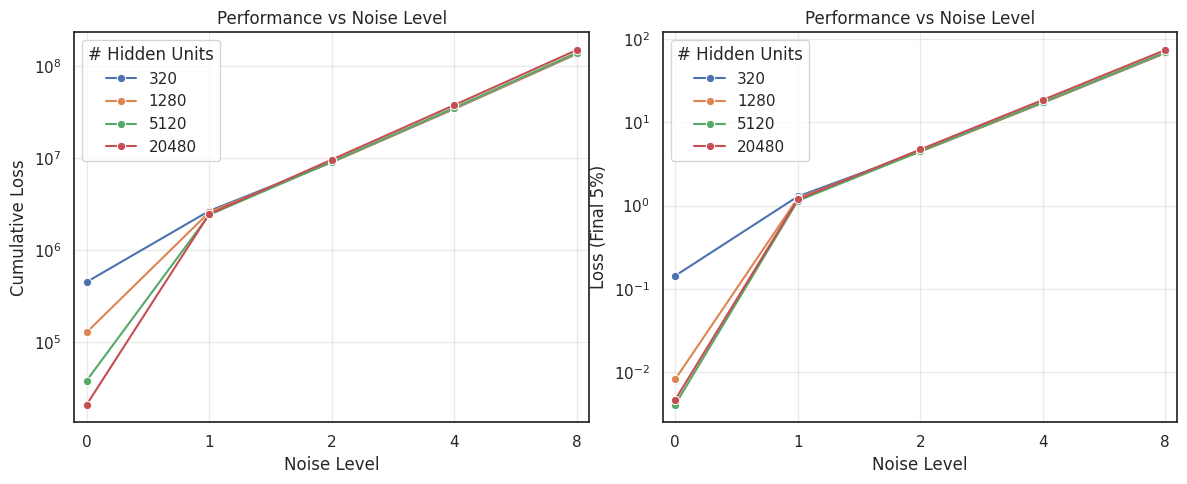

In [13]:
plot_ablation_comparison(
    run_df = run_dfs['noisy_target'],
    config_df = config_dfs['noisy_target'],
    x_col = 'task.noise_std',
    title = 'Performance vs Noise Level',
    x_label = 'Noise Level',
    y_label = 'Loss',
)
plt.show()

plot_ablation_comparison(
    run_df = run_dfs['noisy_target'],
    config_df = config_dfs['noisy_target'],
    x_col = 'task.noise_std',
    title = 'Performance vs Noise Level',
    x_label = 'Noise Level',
    y_label = 'Loss',
)
for ax in plt.gcf().get_axes():
    ax.set_yscale('log')

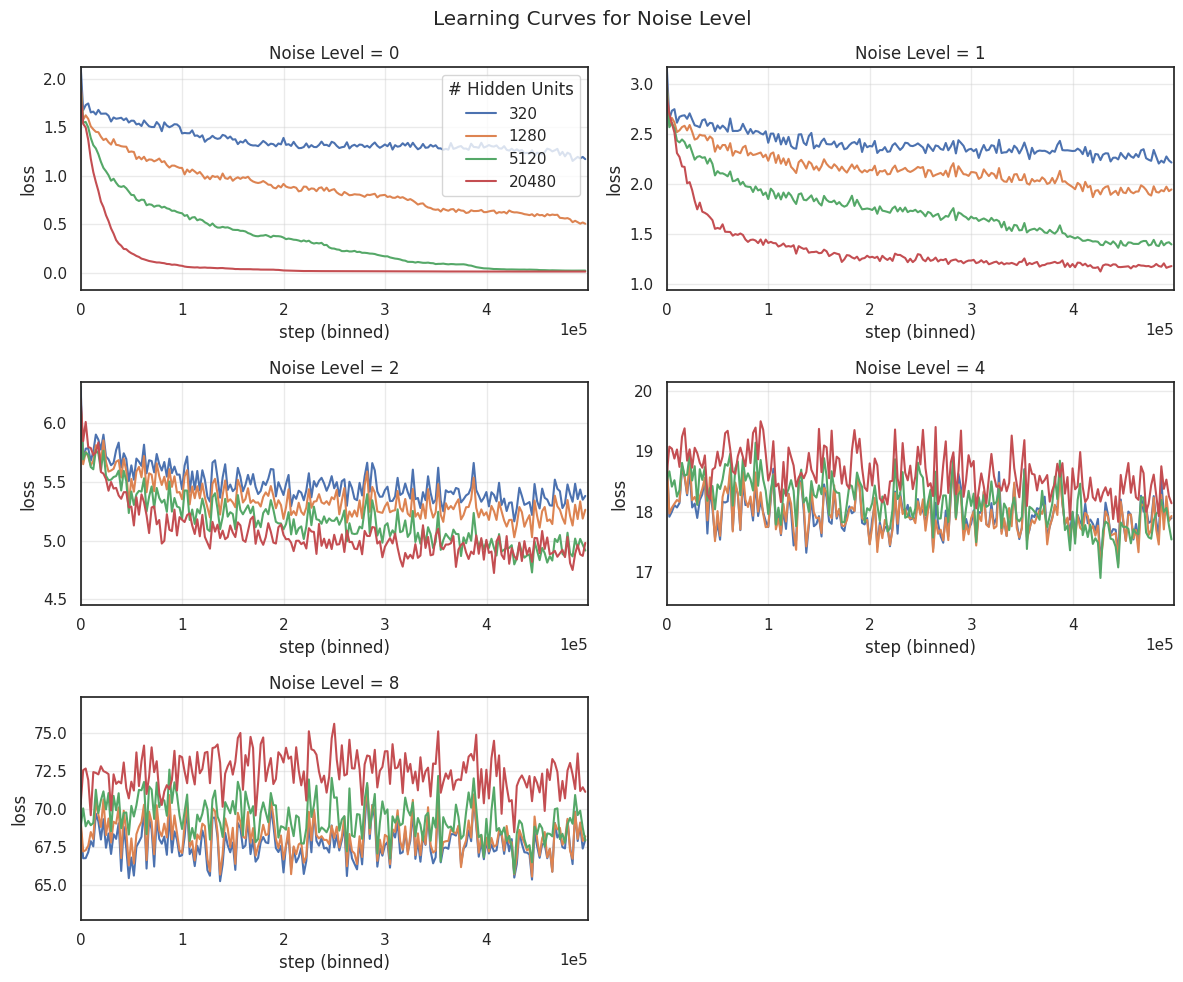

In [92]:
plot_learning_curves(
    run_df = run_dfs['noisy_target'],
    config_df = config_dfs['noisy_target'],
    subplot_col = 'task.noise_std',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Noise Level',
    same_y_axis = False,
)

## Target Non-Stationarity Ablation

In [14]:
nst_config_df = config_dfs['non_stationary_target']
nst_run_df = run_dfs['non_stationary_target']

# Correct flip_rate column
if nst_config_df['task.flip_rate'].dtype == 'object':
    nst_config_df['task.flip_rate'] = nst_config_df['task.flip_rate'].apply(
        lambda x: eval(re.match(r'\${eval:(.*)}', x).group(1)))
    
augmented_nst_config_df = pd.concat([config_dfs['baseline'], nst_config_df])
augmented_nst_run_df = pd.concat([run_dfs['baseline'], nst_run_df])

stat_1_conf_df = augmented_nst_config_df[
    (augmented_nst_config_df['task.n_stationary_layers'] == 1) |
    (augmented_nst_config_df['task.flip_rate'] == 0)
]
unique_run_ids = set(stat_1_conf_df['run_id'].unique())
stat_1_run_df = augmented_nst_run_df[augmented_nst_run_df['run_id'].isin(unique_run_ids)]

stat_0_conf_df = augmented_nst_config_df[
    (augmented_nst_config_df['task.n_stationary_layers'] == 0) |
    (augmented_nst_config_df['task.flip_rate'] == 0)
]
unique_run_ids = set(stat_0_conf_df['run_id'].unique())
stat_0_run_df = augmented_nst_run_df[augmented_nst_run_df['run_id'].isin(unique_run_ids)]

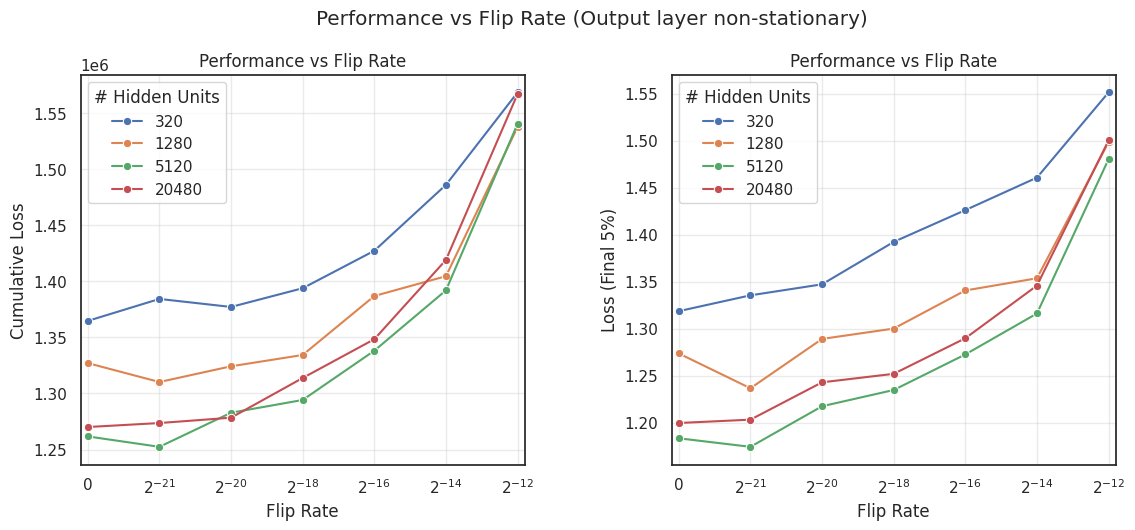

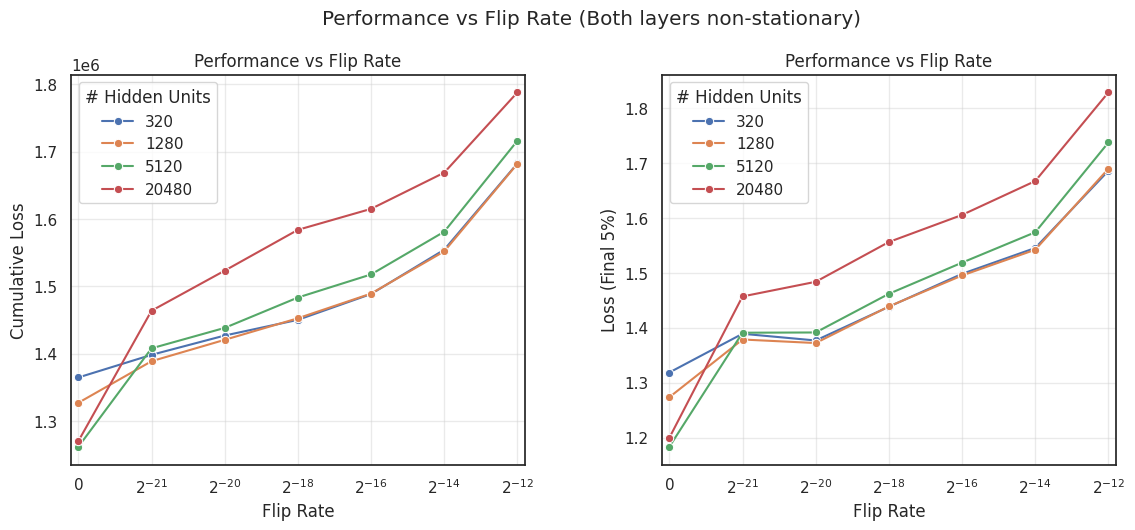

In [15]:
# Plot performance with 1 stationary layer
plot_ablation_comparison(
    run_df = stat_1_run_df,
    config_df = stat_1_conf_df,
    x_col = 'task.flip_rate',
    title = 'Performance vs Flip Rate',
    x_label = 'Flip Rate',
    y_label = 'Loss',
)
plt.suptitle('Performance vs Flip Rate (Output layer non-stationary)', y=1.05)

for ax in plt.gcf().axes:
    x_vals = [float(x.get_text()) for x in ax.get_xticklabels()]
    ax.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_vals])
plt.show()


# Plot performance with 0 stationary layers
plot_ablation_comparison(
    run_df = stat_0_run_df,
    config_df = stat_0_conf_df,
    x_col = 'task.flip_rate',
    title = 'Performance vs Flip Rate',
    x_label = 'Flip Rate',
    y_label = 'Loss',
)
plt.suptitle('Performance vs Flip Rate (Both layers non-stationary)', y=1.05)

for ax in plt.gcf().axes:
    x_vals = [float(x.get_text()) for x in ax.get_xticklabels()]
    ax.set_xticklabels([f'{"0" if x == 0 else f"$2^{{{int(np.log2(x))}}}$"}' for x in x_vals])
plt.show()

Text(0.5, 0.98, 'Performance vs Flip Rate (Both layers non-stationary)')

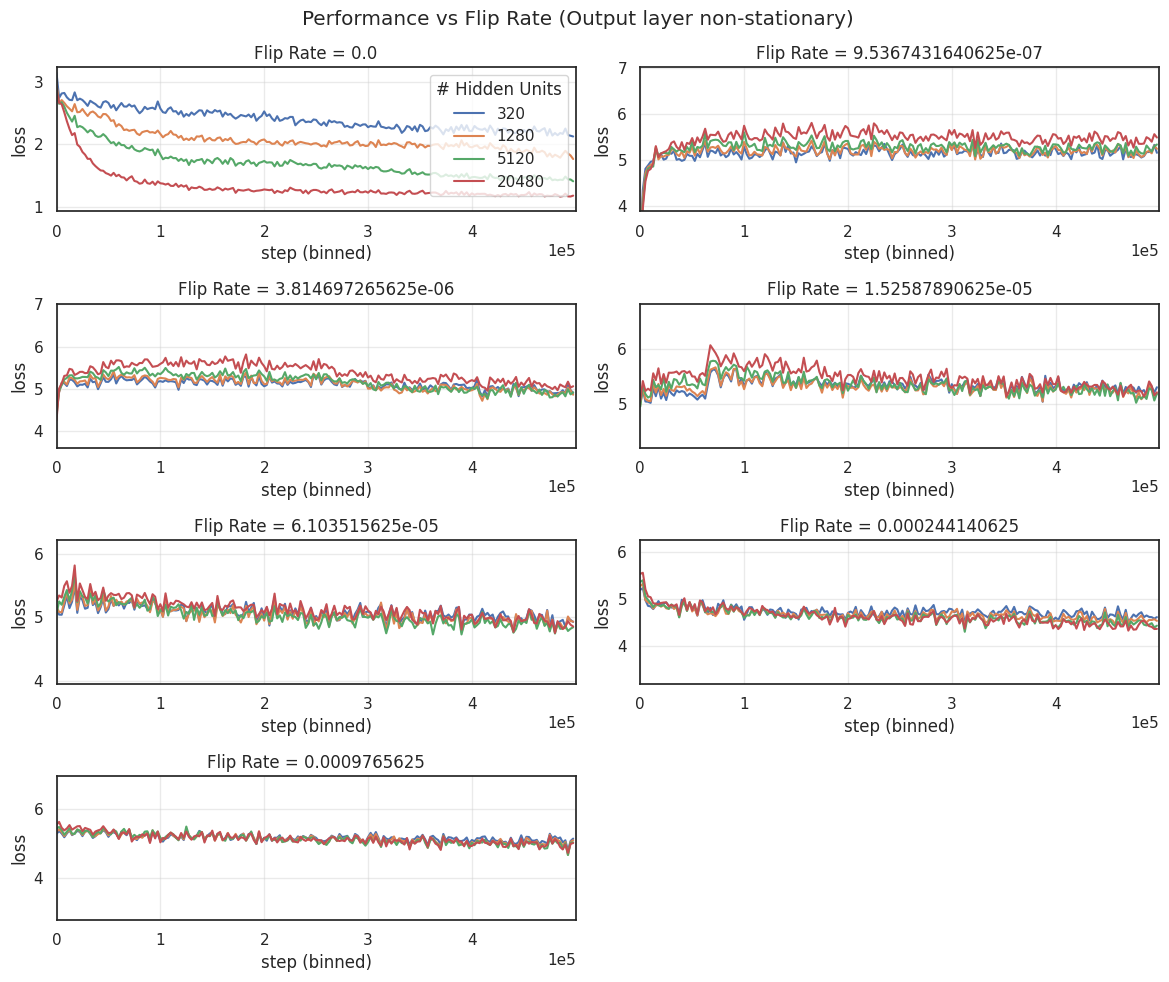

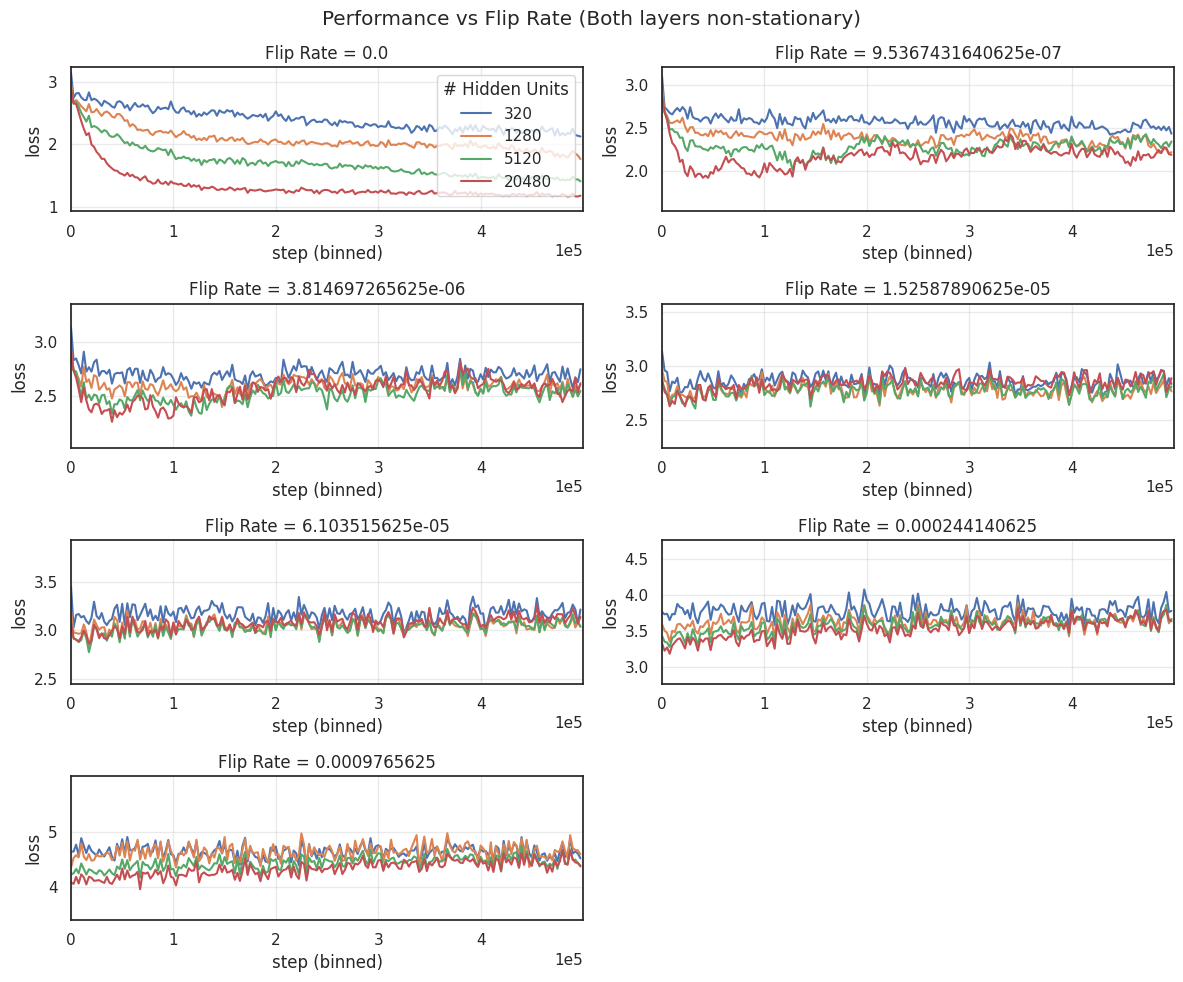

In [129]:
plot_learning_curves(
    run_df = stat_1_run_df,
    config_df = stat_1_conf_df,
    subplot_col = 'task.flip_rate',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Flip Rate',
    same_y_axis = False,
)
plt.suptitle('Performance vs Flip Rate (Output layer non-stationary)')

plot_learning_curves(
    run_df = stat_0_run_df,
    config_df = stat_0_conf_df,
    subplot_col = 'task.flip_rate',
    n_bins = 200,
    figsize = (12, 10),
    max_cols = 2,
    subplot_col_label = 'Flip Rate',
    same_y_axis = False,
)
plt.suptitle('Performance vs Flip Rate (Both layers non-stationary)')